In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torchvision.transforms as T
import glob
import cv2 
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split  
import torch.nn.functional as F


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pwd

/kaggle/working


In [3]:
MAIN_DIR = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"


In [4]:
mask_path = glob.glob(MAIN_DIR + "*/*_mask*")
image_path = [file.replace("_mask" , "") for file in mask_path]

def output(path):
    return 1 if np.max(cv2.imread(path)) > 0 else 0 

data_list = pd.DataFrame({
    'mask_path' : mask_path , 
    'image_path' : image_path , 
    'diagnosis' : [output(file) for file in mask_path]
})


In [5]:
data_list.head()

,mask_path,image_path,diagnosis
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


<BarContainer object of 2 artists>

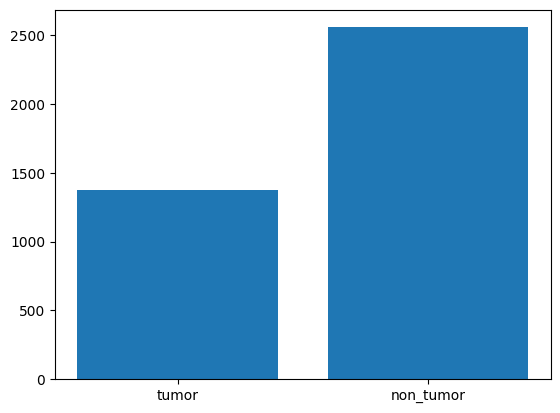

In [6]:
non_tumor = data_list['diagnosis'].value_counts()[0]
tumor =  data_list['diagnosis'].value_counts()[1]

plt.bar(["tumor" , "non_tumor"] , [tumor , non_tumor])

<ipython-input-7-58c3f873b13a>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[1]
<ipython-input-7-58c3f873b13a>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mask_path = row[0]


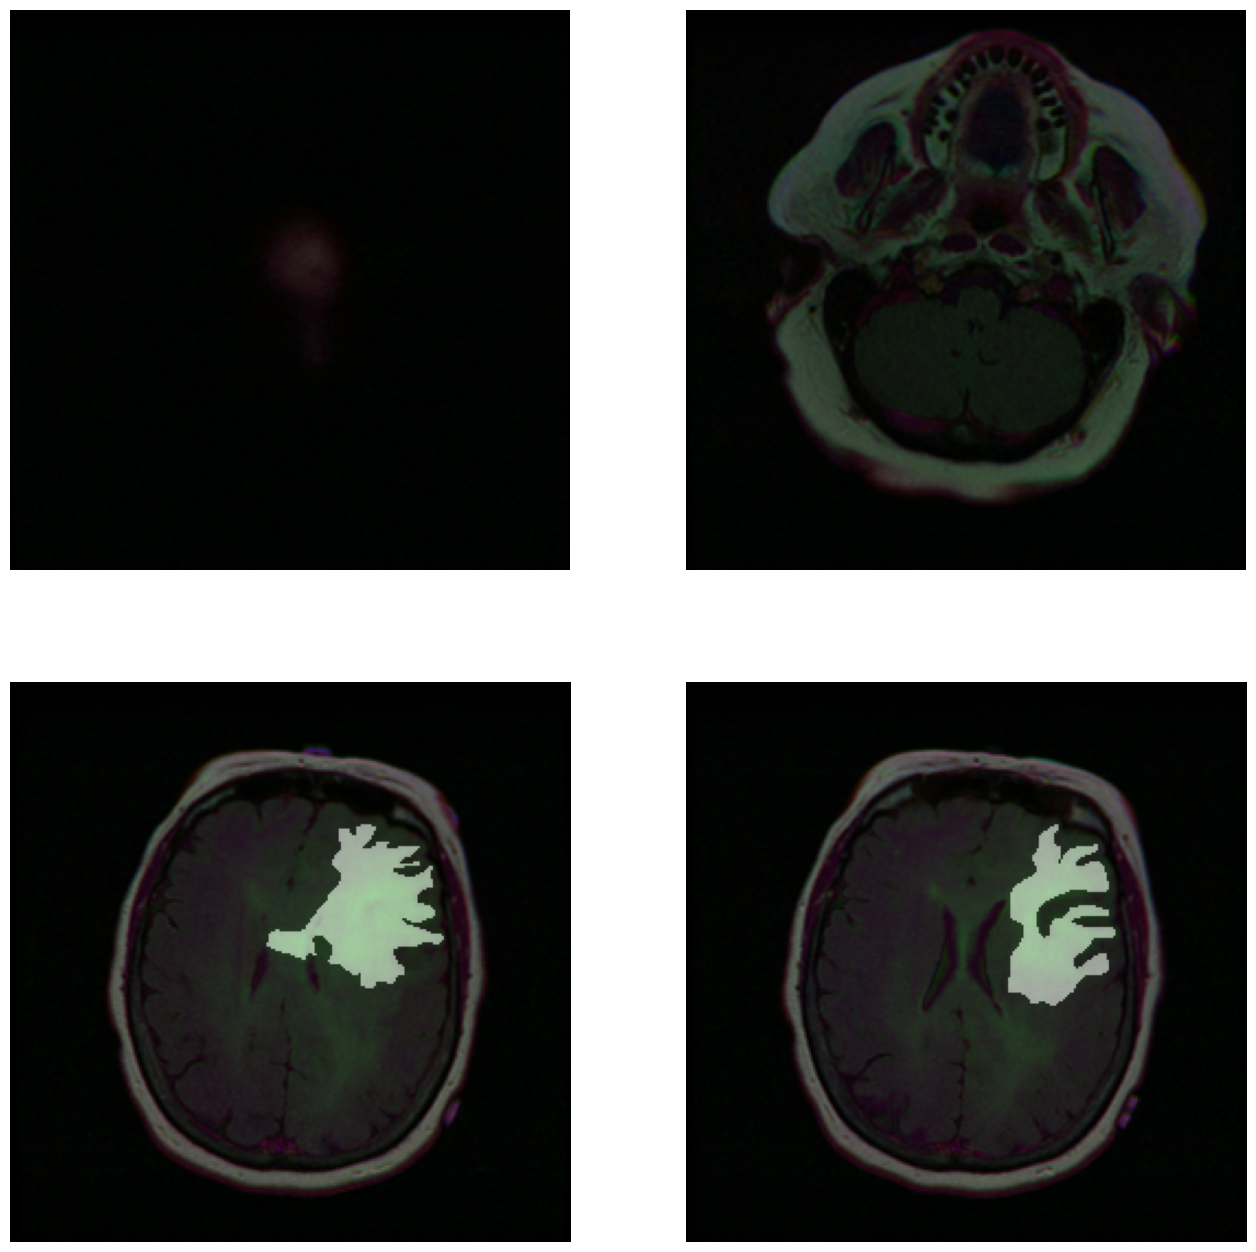

In [7]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(16, 16))

for i , row in (data_list.iloc[0:4, :].iterrows()):
    
    image_path = row[1]  
    mask_path = row[0]   
    
    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)
    
    plt.subplot(2, 2, i+1) 
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5 , cmap='cool')  
    plt.axis('off')


In [8]:
# ## split the dataset in train_test_val 

# train_set, val_test_set = torch.utils.data.random_split(data_list , (0.7 , 0.3))
# print(train_set.__len__() , val_test_set.__len__())
# val_set, test_set = torch.utils.data.random_split(val_test_set , (0.5 , 0.5))
# print(val_set.__len__() , test_set.__len__())


train_df, val_df = train_test_split(data_list, stratify=data_list['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


In [9]:
# dir(train_df)

In [10]:
# define the transformations for the train set and test set 
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  # Resize images to 128x128 pixels
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.RandomRotate90(p=0.5),  
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),  
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  
    A.HorizontalFlip(p=0.5),  
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),  
])

In [11]:
class CustomDataset(Dataset):
    def __init__(self,data,transform):
        self.data = data 
        self.transform = transform 

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, i): 

        image = cv2.imread(self.data.iloc[i , 1])
        image = np.array(image)/255
        mask = cv2.imread(self.data.iloc[i, 0], 0)
        mask = np.array(mask)/255

        if self.transform is not None : 
            aug = self.transform(image = image , mask = mask )
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image , mask 
        
        

In [12]:
train_data = CustomDataset(train_df , train_transform)
test_data = CustomDataset(test_df , test_transform)
val_data = CustomDataset(val_df , val_transform)

In [13]:
batch_size = 16

train_dl = DataLoader(train_data, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  

val_dl = DataLoader(val_data, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)
test_dl = DataLoader(val_data, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

(-0.5, 127.5, 127.5, -0.5)

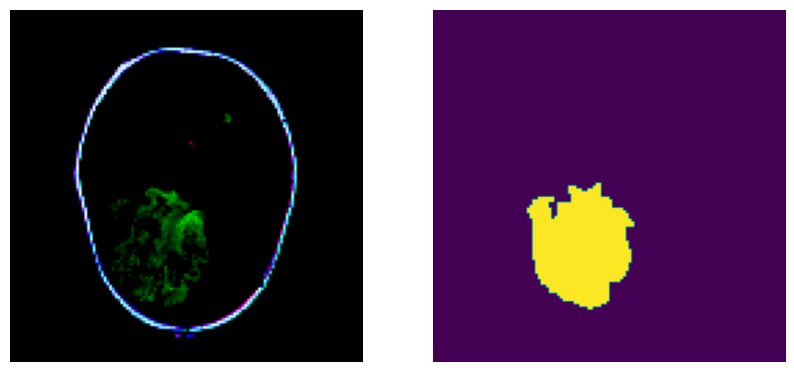

In [33]:
images, masks = next(iter(train_dl))
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks[0].permute(1,2,0))
plt.axis('off')



In [15]:
# now lets define the model 

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)


In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
    # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        
    # Decoder (upsampling path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear) 

        self.outc = OutConv(64, n_classes)
   
    def forward(self, x):
    
    # Encoder path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

    # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)


In [18]:
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


In [19]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [20]:
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
        
# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return train_dices, train_losses

In [21]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)
    
            outputs = model(image)
            loss = loss_func(outputs, mask)
            
    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            
            val_loss += loss
            val_dice += dice
        
        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss

In [22]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)
        
        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)


num_epochs = 20

In [24]:
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/20 |  Train Loss: 1.292, Val Loss: 1.242, Train DICE: 0.469, Val DICE: 0.666
Epoch: 2/20 |  Train Loss: 1.144, Val Loss: 1.149, Train DICE: 0.573, Val DICE: 0.570
Epoch: 3/20 |  Train Loss: 1.058, Val Loss: 1.036, Train DICE: 0.592, Val DICE: 0.785
Epoch: 4/20 |  Train Loss: 0.978, Val Loss: 0.960, Train DICE: 0.641, Val DICE: 0.759
Epoch: 5/20 |  Train Loss: 0.897, Val Loss: 0.861, Train DICE: 0.635, Val DICE: 0.779
Epoch: 6/20 |  Train Loss: 0.796, Val Loss: 0.740, Train DICE: 0.676, Val DICE: 0.760
Epoch: 7/20 |  Train Loss: 0.688, Val Loss: 0.643, Train DICE: 0.699, Val DICE: 0.770
Epoch: 8/20 |  Train Loss: 0.599, Val Loss: 0.572, Train DICE: 0.758, Val DICE: 0.836
Epoch: 9/20 |  Train Loss: 0.571, Val Loss: 0.551, Train DICE: 0.783, Val DICE: 0.856
Epoch: 10/20 |  Train Loss: 0.560, Val Loss: 0.543, Train DICE: 0.791, Val DICE: 0.868
Epoch: 11/20 |  Train Loss: 0.548, Val Loss: 0.521, Train DICE: 0.792, Val DICE: 0.882
Epoch: 12/20 |  Train Loss: 0.533, Val Loss: 0.506, 

In [25]:
def plot_dice(train_dice_history, val_dice_history, epochs):

    fig = plt.figure(figsize=(10, 6))
    plt.plot(range(1 , epochs+1), train_dice_history, label='Train DICE', c="r")
    plt.plot(range(1, epochs+1), val_dice_history, label='Val DICE', c="c")

    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    

In [26]:
def plot_loss(train_loss , val_loss , epochs):
    train_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in train_loss]
    val_loss = [loss.cpu().numpy() if torch.is_tensor(loss) else loss for loss in val_loss]
    plt.figure(figsize=(10,6))
    plt.plot(range(1 , epochs+1) , train_loss , label='Train Loss' , c='r')
    plt.plot(range(1, epochs+1) , val_loss , label='Val Loss', c='c')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    

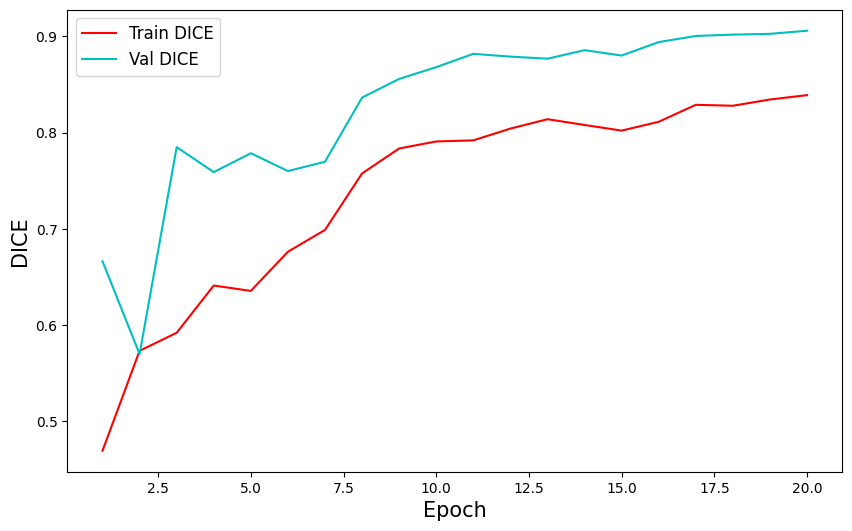

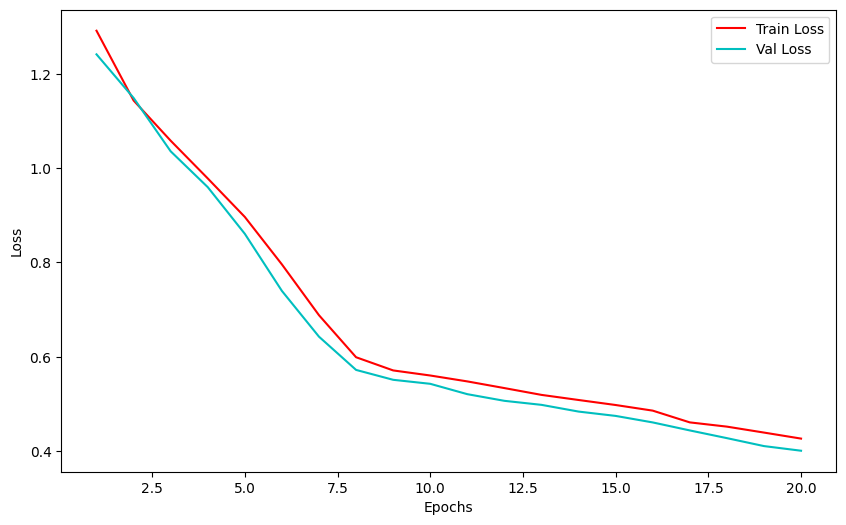

In [27]:
plot_dice(train_dice_history, val_dice_history, num_epochs)
plot_loss(train_loss_history , val_loss_history , num_epochs)

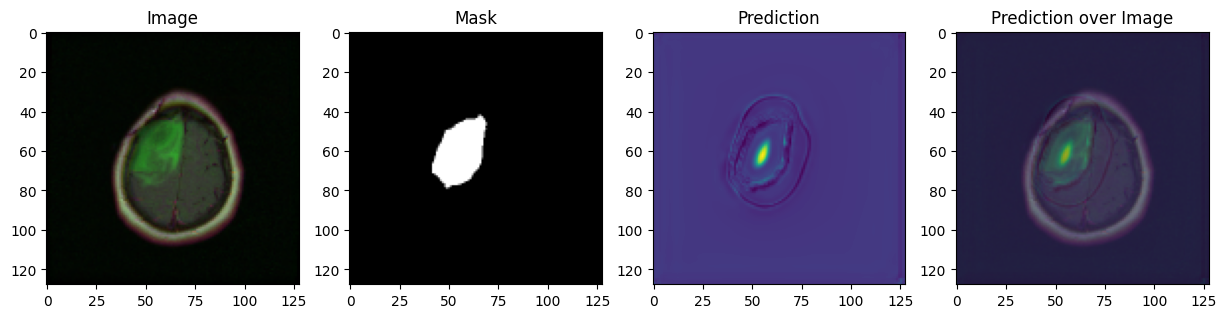

In [49]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
ax[1].imshow(image)
ax[0].set_title("Image")
ax[0].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(pred)
ax[2].set_title("Prediction")
ax[3].imshow(mask)
ax[3].imshow(pred , alpha = 0.5)
ax[3].set_title('Prediction over Image')

plt.show()


In [29]:
torch.save(model.state_dict() , 'best-model.pth')